<a href="https://colab.research.google.com/github/deepika1905/Stock-Market-Prediction-using-Numerical-and-Textual-Analysis/blob/main/Stock_Market_Prediction_using_Numerical_and_Textual_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**GRIP @ The Sparks Foundation**##
##**Author - Deepika Yadav**##
##**Task 1 - Stock Market Prediction using Numerical and Textual Analysis**##

**In this task I tried to create a hybrid model for stock performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.**

**Dataset Used**
-  Historical stock prices :https://finance.yahoo.com/
-  Textual news headlines : https://bit.ly/36fFPI6

In [3]:
#importing libraries 
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##**Importing the Numerical dataset and performing Exploratory Analysis**##

In [4]:
#Loading data
stock_price = pd.read_csv('stock_price.csv')
stock_headlines = pd.read_csv('india-news-headlines.csv')

In [5]:
# displaying stock price dataset
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-13,277.519989,282.850006,277.390015,280.980011,278.704254,26120100
1,2021-07-14,282.350006,283.660004,280.549988,282.510010,280.221832,23113700
2,2021-07-15,282.000000,282.510010,279.829987,281.029999,278.753815,22604200
3,2021-07-16,282.070007,284.100006,279.459991,280.750000,278.476105,26186800
4,2021-07-19,278.929993,280.369995,274.450012,277.010010,274.766418,32935600


In [6]:
# displaying stock news headlines dataset
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


##**Feature Engineering**##
-  **Feature engineering refers to manipulation — addition, deletion, combination, mutation — of your data set to improve machine learning model training, leading to better performance and greater accuracy. Effective feature engineering is based on sound knowledge of the business problem and the available data sources.**

In [7]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(252, 3650970)

In [8]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

##**Stock Price Data**##

In [9]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2021-07-13,280.980011,277.519989,282.850006,277.390015,26120100
2021-07-14,282.510010,282.350006,283.660004,280.549988,23113700
2021-07-15,281.029999,282.000000,282.510010,279.829987,22604200
2021-07-16,280.750000,282.070007,284.100006,279.459991,26186800
2021-07-19,277.010010,278.929993,280.369995,274.450012,32935600
...,...,...,...,...,...
2022-07-06,266.209991,263.750000,267.989990,262.399994,23824400
2022-07-07,268.399994,265.119995,269.059998,265.019989,20859900
2022-07-08,267.660004,264.790009,268.100006,263.290009,19648100


##**Stock News Headlines Data**##

In [10]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


##**Combined Stock Data**##

In [11]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2021-07-13,280.980011,277.519989,282.850006,277.390015,26120100.0,Horoscope Today; 13 July 2021: Check astrologi...
2021-07-14,282.510010,282.350006,283.660004,280.549988,23113700.0,I was once told I'd be a big star; since I beg...
2021-07-15,281.029999,282.000000,282.510010,279.829987,22604200.0,Resolution of 95 IL&FS cos' debt to spill into...
2021-07-16,280.750000,282.070007,284.100006,279.459991,26186800.0,Horoscope Today; 16 July 2021: Check astrologi...
2021-07-19,277.010010,278.929993,280.369995,274.450012,32935600.0,Understanding the workings of a High Risk Preg...
...,...,...,...,...,...,...
2022-03-25,303.679993,305.230011,305.500000,299.290009,22566500.0,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,310.700012,304.329987,310.799988,304.329987,29578200.0,As fashion becomes democratic; demand for styl...
2022-03-29,315.410004,313.910004,315.820007,309.049988,30393400.0,Bobby Deol: Like my dad; I hope to be working ...
2022-03-30,313.859985,313.760010,315.950012,311.579987,28163600.0,"I will not give in to trends: Dossmode,The tim..."


##**Calculating Sentiment Scores**##

In [12]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2021-07-13,280.980011,277.519989,282.850006,277.390015,26120100.0,Horoscope Today; 13 July 2021: Check astrologi...,,,,
2021-07-14,282.510010,282.350006,283.660004,280.549988,23113700.0,I was once told I'd be a big star; since I beg...,,,,
2021-07-15,281.029999,282.000000,282.510010,279.829987,22604200.0,Resolution of 95 IL&FS cos' debt to spill into...,,,,
2021-07-16,280.750000,282.070007,284.100006,279.459991,26186800.0,Horoscope Today; 16 July 2021: Check astrologi...,,,,
2021-07-19,277.010010,278.929993,280.369995,274.450012,32935600.0,Understanding the workings of a High Risk Preg...,,,,


In [13]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2021-07-13,280.980011,277.519989,282.850006,277.390015,26120100.0,Horoscope Today; 13 July 2021: Check astrologi...,-0.9999,0.153,0.776,0.070
2021-07-14,282.510010,282.350006,283.660004,280.549988,23113700.0,I was once told I'd be a big star; since I beg...,-0.9999,0.152,0.771,0.077
2021-07-15,281.029999,282.000000,282.510010,279.829987,22604200.0,Resolution of 95 IL&FS cos' debt to spill into...,-0.9998,0.120,0.815,0.065
2021-07-16,280.750000,282.070007,284.100006,279.459991,26186800.0,Horoscope Today; 16 July 2021: Check astrologi...,-0.9999,0.142,0.790,0.068
2021-07-19,277.010010,278.929993,280.369995,274.450012,32935600.0,Understanding the workings of a High Risk Preg...,-0.9999,0.139,0.792,0.070


##**Finalising Stock Data and writing to Disk**##

In [14]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2021-07-13,280.980011,-0.9999,0.153,0.776,0.070,277.519989,282.850006,277.390015,26120100.0
2021-07-14,282.510010,-0.9999,0.152,0.771,0.077,282.350006,283.660004,280.549988,23113700.0
2021-07-15,281.029999,-0.9998,0.120,0.815,0.065,282.000000,282.510010,279.829987,22604200.0
2021-07-16,280.750000,-0.9999,0.142,0.790,0.068,282.070007,284.100006,279.459991,26186800.0
2021-07-19,277.010010,-0.9999,0.139,0.792,0.070,278.929993,280.369995,274.450012,32935600.0


In [23]:
# writing the prepared stock_data to disk
stock_data.to_csv('/content/drive/MyDrive/The Sparks Foundation/stock_datafinal.csv')

##**Reading Stock Data**##

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('/content/drive/MyDrive/The Sparks Foundation/stock_datafinal.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-07-13,280.980011,-0.9999,0.153,0.776,0.070,277.519989,282.850006,277.390015,26120100.0
2021-07-14,282.510010,-0.9999,0.152,0.771,0.077,282.350006,283.660004,280.549988,23113700.0
2021-07-15,281.029999,-0.9998,0.120,0.815,0.065,282.000000,282.510010,279.829987,22604200.0
2021-07-16,280.750000,-0.9999,0.142,0.790,0.068,282.070007,284.100006,279.459991,26186800.0
2021-07-19,277.010010,-0.9999,0.139,0.792,0.070,278.929993,280.369995,274.450012,32935600.0


##**Feature Engineering of Stock Data**##

In [27]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(183, 9)

In [28]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [29]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,1.830000e+02
mean,306.468252,-0.977628,0.131470,0.792557,0.076000,306.503934,309.390766,303.145628,2.913889e+07
std,18.604619,0.208271,0.016963,0.020762,0.011181,18.711091,18.593059,18.681708,1.180788e+07
min,275.850006,-0.999900,0.078000,0.743000,0.051000,272.510010,280.369995,270.000000,1.390020e+07
25%,293.094986,-0.999900,0.118500,0.777000,0.069000,292.295013,295.074997,288.970001,2.092090e+07
50%,301.600006,-0.999800,0.134000,0.791000,0.076000,302.339996,304.500000,299.290009,2.707320e+07
75%,323.090012,-0.999700,0.142500,0.807000,0.083000,322.085007,325.495010,317.410004,3.425455e+07
max,343.109985,0.999800,0.168000,0.857000,0.124000,344.619995,349.670013,342.200012,9.042890e+07


In [30]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 2021-07-13 to 2022-03-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     183 non-null    float64
 1   compound  183 non-null    float64
 2   negative  183 non-null    float64
 3   neutral   183 non-null    float64
 4   positive  183 non-null    float64
 5   Open      183 non-null    float64
 6   High      183 non-null    float64
 7   Low       183 non-null    float64
 8   Volume    183 non-null    float64
dtypes: float64(9)
memory usage: 14.3+ KB


##**Exploratory Data Analysis of Stock Data**##

Text(0, 0.5, 'Close Price ($)')

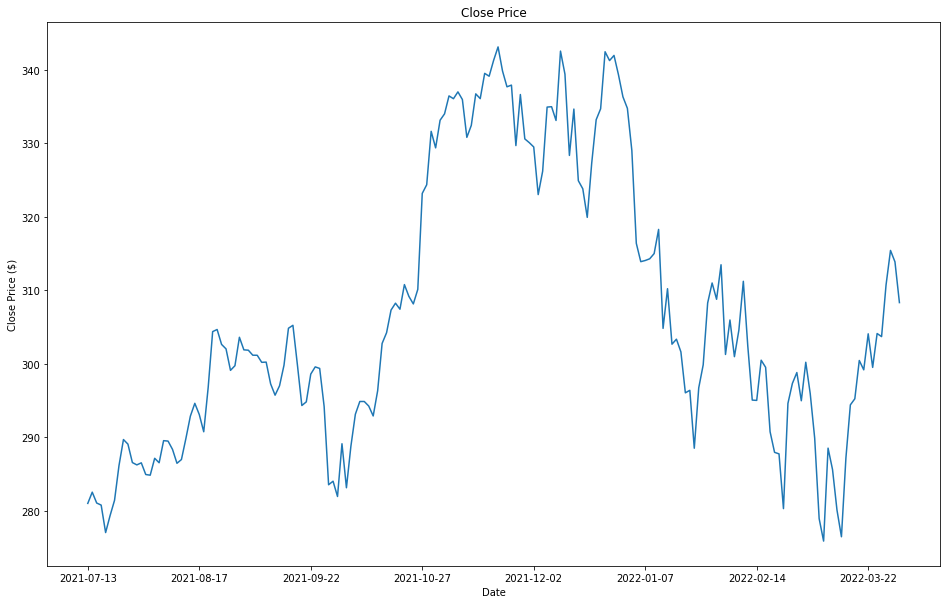

In [31]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [32]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-21,280.428576,-0.999871,0.139000,0.788429,0.072571,279.971427,282.282859,277.890002,2.594063e+07
2021-07-22,281.165719,-0.999871,0.136571,0.790571,0.073000,280.874285,282.792860,278.751430,2.554977e+07
2021-07-23,282.188577,-0.999871,0.135857,0.794000,0.070143,281.591426,283.697143,279.601432,2.550040e+07


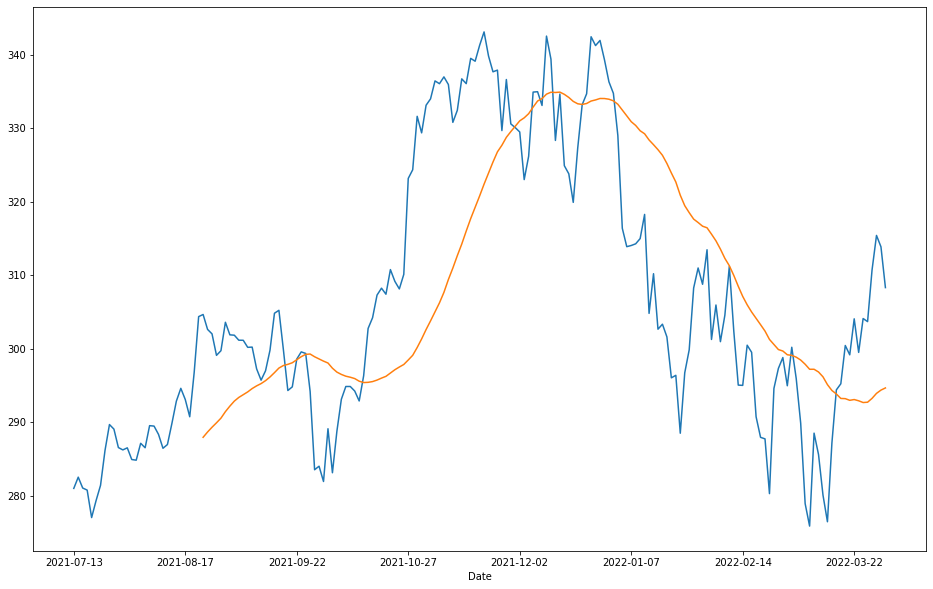

In [33]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [34]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-07-13,280.980011,-0.9999,0.153,0.776,0.070,277.519989,282.850006,277.390015,26120100.0
2021-07-14,282.510010,-0.9999,0.152,0.771,0.077,282.350006,283.660004,280.549988,23113700.0
2021-07-15,281.029999,-0.9998,0.120,0.815,0.065,282.000000,282.510010,279.829987,22604200.0
2021-07-16,280.750000,-0.9999,0.142,0.790,0.068,282.070007,284.100006,279.459991,26186800.0
2021-07-19,277.010010,-0.9999,0.139,0.792,0.070,278.929993,280.369995,274.450012,32935600.0
...,...,...,...,...,...,...,...,...,...
2022-03-25,303.679993,-0.9999,0.160,0.774,0.066,305.230011,305.500000,299.290009,22566500.0
2022-03-28,310.700012,-0.9999,0.151,0.763,0.086,304.329987,310.799988,304.329987,29578200.0
2022-03-29,315.410004,-0.9998,0.131,0.789,0.080,313.910004,315.820007,309.049988,30393400.0


##**Data Preparation for Modelling**##

In [35]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 145
Number of records in Test Data: 38


In [36]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2021-07-14    282.510010
2021-07-15    281.029999
2021-07-16    280.750000
2021-07-19    277.010010
2021-07-20    279.320007
                 ...    
2022-03-25    303.679993
2022-03-28    310.700012
2022-03-29    315.410004
2022-03-30    313.859985
2022-03-31    308.309998
Name: Close, Length: 182, dtype: float64

In [37]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2021-07-14,282.510010,281.029999,-0.9999,-0.9998,23113700.0,282.350006,283.660004,280.549988
2021-07-15,281.029999,280.750000,-0.9998,-0.9999,22604200.0,282.000000,282.510010,279.829987
2021-07-16,280.750000,277.010010,-0.9999,-0.9999,26186800.0,282.070007,284.100006,279.459991
2021-07-19,277.010010,279.320007,-0.9999,-0.9999,32935600.0,278.929993,280.369995,274.450012
2021-07-20,279.320007,281.399994,-0.9999,-0.9998,26259700.0,278.029999,280.970001,276.260010
2021-07-21,281.399994,286.140015,-0.9998,-0.9999,24364300.0,278.899994,281.519989,277.290009
2021-07-22,286.140015,289.670013,-0.9999,-0.9999,23384100.0,283.839996,286.420013,283.420013
2021-07-23,289.670013,289.049988,-0.9999,-0.9998,22768100.0,287.369995,289.989990,286.500000
2021-07-26,289.049988,286.540009,-0.9998,-0.9999,23176100.0,289.000000,289.690002,286.640015


##**Setting the Target Variable and the Feature Dataset**##

In [38]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2021-07-14    281.029999
2021-07-15    280.750000
2021-07-16    277.010010
2021-07-19    279.320007
2021-07-20    281.399994
                 ...    
2022-03-24    303.679993
2022-03-25    310.700012
2022-03-28    315.410004
2022-03-29    313.859985
2022-03-30    308.309998
Name: close_price_shifted, Length: 181, dtype: float64

In [39]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2021-07-14,282.510010,-0.9999,-0.9998,23113700.0,282.350006,283.660004,280.549988
2021-07-15,281.029999,-0.9998,-0.9999,22604200.0,282.000000,282.510010,279.829987
2021-07-16,280.750000,-0.9999,-0.9999,26186800.0,282.070007,284.100006,279.459991
2021-07-19,277.010010,-0.9999,-0.9999,32935600.0,278.929993,280.369995,274.450012
2021-07-20,279.320007,-0.9999,-0.9998,26259700.0,278.029999,280.970001,276.260010
...,...,...,...,...,...,...,...
2022-03-24,304.100006,-0.9999,-0.9999,24484500.0,299.140015,304.200012,298.320007
2022-03-25,303.679993,-0.9999,-0.9999,22566500.0,305.230011,305.500000,299.290009
2022-03-28,310.700012,-0.9999,-0.9998,29578200.0,304.329987,310.799988,304.329987


##**Scaling the Target Variable and the Feature Dataset**##
-  **Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.**

In [40]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.80196235, -1.        , -0.99989998, ..., -0.72708368,
         -0.90505027, -0.70775661],
        [-0.84597102, -0.99989998, -1.        , ..., -0.73679124,
         -0.93823912, -0.72770124],
        [-0.85429689, -1.        , -1.        , ..., -0.73484956,
         -0.8923518 , -0.73795043],
        ...,
        [ 0.03627764, -1.        , -0.99989998, ..., -0.11745989,
         -0.12178975, -0.04903099],
        [ 0.17633096, -0.99989998, -1.        , ...,  0.14824581,
          0.0230881 ,  0.08171694],
        [ 0.13024058, -1.        , -1.        , ...,  0.14408566,
          0.02684005,  0.1518    ]]), array([[-0.84597102],
        [-0.85429689],
        [-0.96550686],
        [-0.89681826],
        [-0.83496908],
        [-0.69402283],
        [-0.58905705],
        [-0.60749372],
        [-0.68212886],
        [-0.69164442],
        [-0.68331855],
        [-0.73059766],
        [-0.73327375],
        [-0.66488277],
        [-0.68302089],
        [-0.59351807],
      

##**Dividing the dataset into Training and Test**##
-  **Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.**

In [41]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (145, 7) and y: (145, 1)
Number of rows and columns in the Test set X: (35, 7) and y: (35, 1)


##**Reshaping the Feature Dataset**##

In [42]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (145, 7, 1)
Shape of Test set X: (35, 7, 1)


##**Stock Data Modelling**##

In [43]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [44]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.35, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
12/12 [==============================] - 7s 133ms/step - loss: 0.2633 - val_loss: 0.3711
Epoch 2/50
12/12 [==============================] - 0s 19ms/step - loss: 0.1693 - val_loss: 0.1808
Epoch 3/50
12/12 [==============================] - 0s 19ms/step - loss: 0.0829 - val_loss: 0.1715
Epoch 4/50
12/12 [==============================] - 0s 19ms/step - loss: 0.0533 - val_loss: 0.0877
Epoch 5/50
12/12 [==============================] - 0s 20ms/step - loss: 0.0383 - val_loss: 0.1076
Epoch 6/50
12/12 [==============================] - 0s 18ms/step - loss: 0.0374 - val_loss: 0.1026
Epoch 7/50
12/12 [==============================] - 0s 19ms/step - loss: 0.0361 - val_loss: 0.0922
Epoch 8/50
12/12 [==============================] - 0s 19ms/step - loss: 0.0331 - val_loss: 0.0883
Epoch 9/50
12/12 [==============================] - 0s 19ms/step - loss: 0.0420 - val_loss: 0.0959
Epoch 10/50
12/12 [==============================] - 0s 21ms/step - loss: 0.0319 - val_loss: 0.1035
Epoch 11

In [47]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('/content/drive/MyDrive/The Sparks Foundation/model.h5')
print('Model is saved to the disk')

Model is saved to the disk


##**Predictions**##

In [48]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[311.4737 ],
       [306.7863 ],
       [299.92493],
       [294.6315 ],
       [298.6057 ]], dtype=float32)

##**Model Evaluation**##

In [49]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

35/35 [==============================] - 0s 3ms/step - loss: 0.0380
Train Loss = 0.0266
Test Loss = 0.038


In [50]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 295.8193


In [51]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 295.8193


##**Plotting the Predictions against unseen data**##

In [52]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

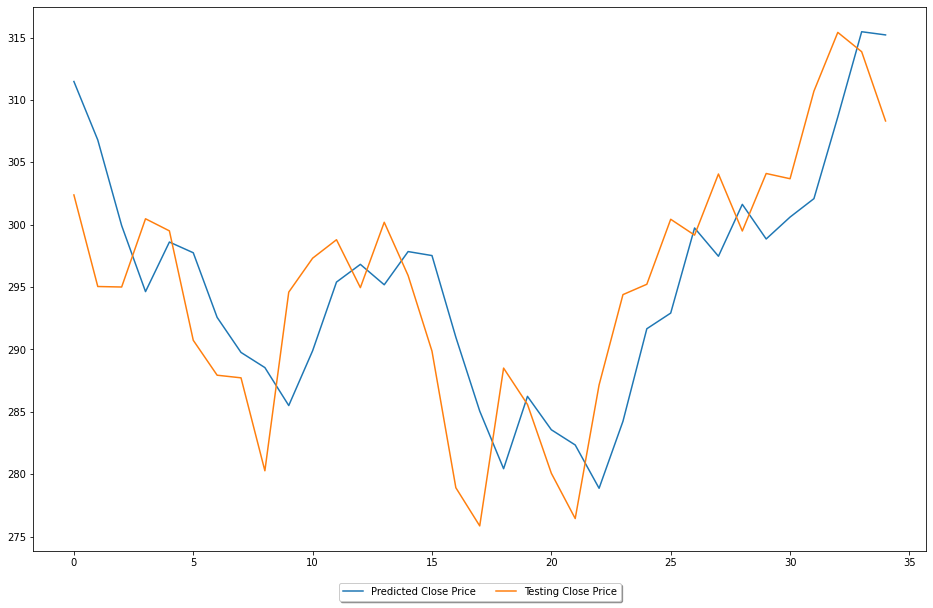

In [53]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

#**THANK YOU**#